# Produce training data via SAME-ECOS simulation 

In [6]:
import SAME_ECOS_functions as se
import time
import datetime
import numpy as np
import scipy.io as sio
import math
import itertools

In [7]:
### An example to display the usage of a SAME-ECOS function
se.produce_training_data?

In [8]:
### load the decay library for 32-echo GRASE sequence
EPG_decay_lib = se.load_decay_lib('EPG_decay_library_32echo.mat')

In [9]:
### the decay library should have dimensions with 1st dim: T2 times (1-2000ms), 2nd dim: refocus flip angles (1-180 degrees), 3rd dim: echoes
EPG_decay_lib.shape

(2000, 180, 32)

In [10]:
### use 'se.mp_yield_training_data' to accerelate the training data production by multiprocessing
### use 'se.produce_training_data' if encounter problems with the multiprocessing module
data = se.mp_yield_training_data(se.produce_training_data,
                                 EPG_decay_lib,
                                 realizations=1000000,
                                 ncores=12, # number of cpu cores to use
                                 SNR_boundary_low=50,
                                 SNR_boundary_high=500,
                                 echo_3=30, # 3rd echo time is used to estimate the least plausible signal allowed in the simulation
                                 echo_last=320,
                                 echo_train_num=32,
                                 num_t2_basis=40, # number of t2 basis to depict the simulated T2 spectrum 
                                 FA_min=50, # minimal refocusing flip angle in the simulation
                                 peak_width=1, # the peak width of the simulated gaussian shaped T2 peaks
                                 T2_min_universal=None,
                                 T2_max_universal=None, # a default of 2000ms will be assigned if None is given
                                 exclude_M_max=False, # exclude the maximum number of T2 components calculated from resolution limit
                                 )

In [11]:
data.keys()

dict_keys(['T2_location', 'T2_amplitude', 'decay_curve', 'decay_curve_with_noise', 'train_label', 'train_label_gaussian', 'num_T2_SNR_FA'])

produced training data contains
- T2_location: T2 peak locations of each realization
- T2_amplitude: T2 peak amplitudes of each realization
- decay_curve: the pure signal at each echo of each realization
- decay_curve_with_noise: the signal at each echo of each realization with noise added
- train_label: the T2 spectrum (each T2 peak is depicted by two nearest basis t2s)
- train_label_gaussian: the T2 spectrum (each T2 peak is depicted by gaussian shaped basis t2s)
- num_T2_SNR_FA: a collection array of number of T2 peaks, selected SNR, and selected flip angle of each realization

# SAME-ECOS model training

In [12]:
import sklearn
import tensorflow as tf
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
### store training input data in variable x
x = data['decay_curve_with_noise']
### normalization the input data to its first echo
x=x/x[:,0].reshape(x.shape[0],1) 
x.shape

(1000000, 32)

In [14]:
### store training label in variable y
y = data['train_label_gaussian']
y.shape

(1000000, 40)

In [15]:
### split the dataset into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=10)

In [16]:
print('training x: '+ str(x_train.shape))
print('training y: '+ str(y_train.shape))
print('validation x: '+ str(x_val.shape))
print('validation y: '+ str(y_val.shape))
print('testing x: '+ str(x_test.shape))
print('testing y: '+ str(y_test.shape))

training x: (810000, 32)
training y: (810000, 40)
validation x: (90000, 32)
validation y: (90000, 40)
testing x: (100000, 32)
testing y: (100000, 40)


In [17]:
### Setting up neural network hyperparameters
hidden_layers=[100, 500, 1000, 1000, 500] # a list of nodes in each hidden layer and can be changed as you wish
output_layer_nodes = y.shape[1]
Batch_norm = 'yes' # use batch normalization
acti='selu' # activation function
initial='lecun_normal' # weight initialization
selected_metrics=[tf.keras.metrics.CosineSimilarity(axis=-1)]
selected_optimizer = keras.optimizers.Adamax(lr=0.005)
# loss_function = 'cosine_similarity'
loss_function = 'categorical_crossentropy' # other loss functions can be used as well.
# loss_function = 'mean_squared_error'
l1_strength = 0.1 # L1 regularization parameter
l2_strength = 0.1 # L2 regularization parameter
num_epoch = 50

In [18]:
### Train and test the neural network model, and store training and testing history in 'NN_training.txt'
f = open("NN_training.txt", "a")
now = datetime.datetime.now()
f.write("Date and Time: {} \n".format(now.strftime("%Y-%m-%d %H:%M:%S")))
f.write('selected hidden layer structure = {} \n'.format(hidden_layers))
f.write('activation = {}, initialization = {} \n'.format(acti, initial))
f.write('Batch_norm = {}, loss_function = {}, regularization_strength = {},\nselected_optimizer = {} \n \n \n'.format(
    Batch_norm, loss_function, l2_strength, selected_optimizer))

keras.backend.clear_session()
model = keras.Sequential()
if Batch_norm == 'yes':
    model.add(keras.layers.BatchNormalization())
for nodes in hidden_layers:
    model.add(keras.layers.Dense(
        nodes, kernel_initializer=initial, activation=acti))
    if Batch_norm == 'yes':
        model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(output_layer_nodes, kernel_initializer=initial, activation='softmax',
          activity_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)))

model.compile(optimizer=selected_optimizer, loss=loss_function, metrics=selected_metrics)

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_cosine_similarity', patience=15),
                  keras.callbacks.ModelCheckpoint(filepath='NN_model_example.h5',monitor='val_cosine_similarity',save_best_only=True),
                  keras.callbacks.ReduceLROnPlateau(monitor='cosine_similarity', factor=0.5, patience=3)]

start_time = time.time()
history = model.fit(x_train, y_train, epochs=40, batch_size=256,
                    callbacks=callbacks_list, validation_data=(x_val, y_val))

print("--- %.2f seconds ---" % (time.time() - start_time))
f.write("--- Training time %.2f seconds --- \n" % (time.time() - start_time))
print('training stopped at epoch = {}'.format(len(history.history['lr'])))
f.write('training stopped at epoch = {} \n \n'.format(
    len(history.history['lr'])))
f.write('validation similarity = {} \n \n'.format(list(round(i, 4)
        for i in history.history['val_cosine_similarity'])))
f.write('learning rate = {} \n \n'.format(list(round(i, 6)
        for i in history.history['lr'])))

### apply trained model to the test set
NN_predict = model.predict(x_test)

### evaluate the model performance using cosine similarity scores
similarity_score = np.zeros((y_test.shape[0], 1))
for item in range(y_test.shape[0]):
    similarity_score[item, :] = cosine_similarity(
        NN_predict[item, :].reshape(1, -1), y_test[item, :].reshape(1, -1))
print('Average similarity for each spectrum in the test set = {} +/- {} \n'.format(
    similarity_score.mean(), similarity_score.std()))
f.write('Average similarity for each spectrum in the test set = {} +/- {} \n'.format(
    similarity_score.mean(), similarity_score.std()))
f.write('#############################################\n')
f.write('\n \n')
f.close()

Epoch 1/40
3165/3165 [==============================] - 36s 11ms/step - loss: 2.9791 - cosine_similarity: 0.7226 - val_loss: 2.9281 - val_cosine_similarity: 0.7334
Epoch 2/40
3165/3165 [==============================] - 35s 11ms/step - loss: 2.8327 - cosine_similarity: 0.7742 - val_loss: 2.9197 - val_cosine_similarity: 0.7383
Epoch 3/40
3165/3165 [==============================] - 35s 11ms/step - loss: 2.7942 - cosine_similarity: 0.7888 - val_loss: 2.8761 - val_cosine_similarity: 0.7632
Epoch 4/40
3165/3165 [==============================] - 35s 11ms/step - loss: 2.7690 - cosine_similarity: 0.7999 - val_loss: 2.7907 - val_cosine_similarity: 0.7935
Epoch 5/40
3165/3165 [==============================] - 35s 11ms/step - loss: 2.7240 - cosine_similarity: 0.8186 - val_loss: 2.7389 - val_cosine_similarity: 0.8141
Epoch 6/40
3165/3165 [==============================] - 35s 11ms/step - loss: 2.6983 - cosine_similarity: 0.8290 - val_loss: 2.7264 - val_cosine_similarity: 0.8174
Epoch 7/40
3165/

# Evaluate the trained model performance 

In [19]:
import matplotlib.pyplot as plt

In [20]:
### use 40 basis t2s to depict the spectrum  
t2_basis = se.t2_basis_generator(5,2000,40)

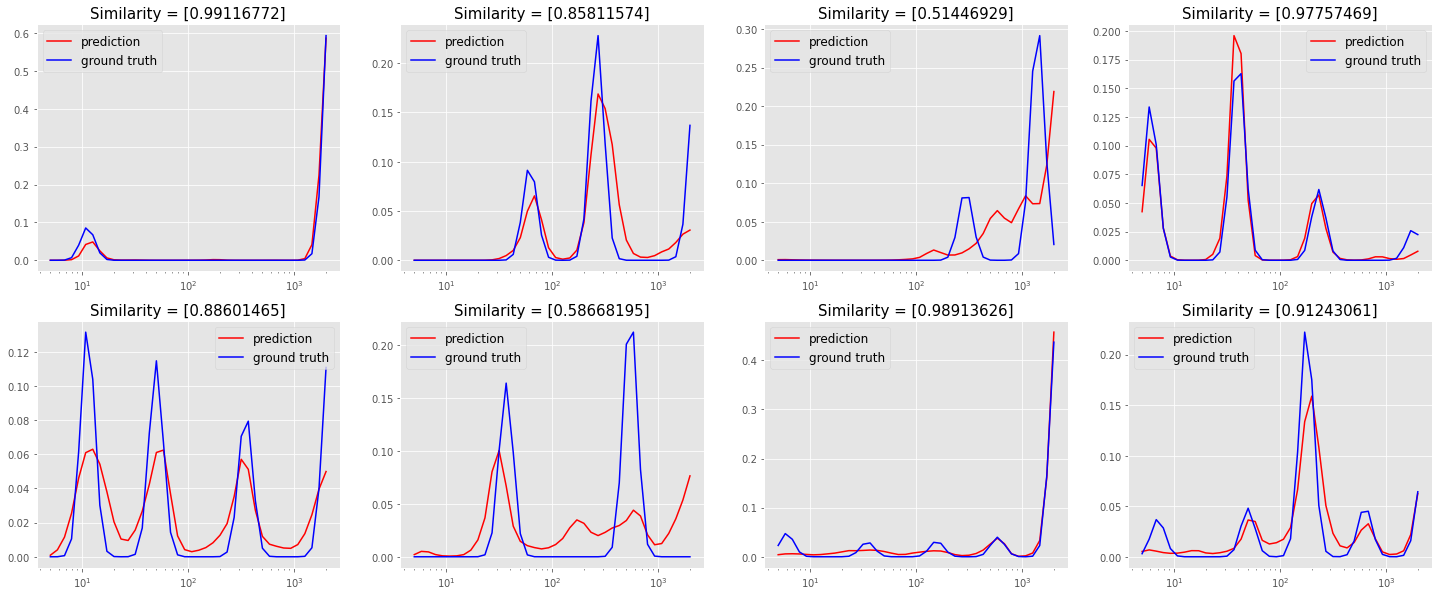

In [21]:
### randomly pick a few test examples and plot them
nrow = 2
ncol = 4
plt.figure(figsize=(25,10))
plt.style.use('ggplot')
for i in range(nrow*ncol):
    plt.subplot(nrow, ncol, i+1)
    random_pick = np.random.randint(0, y_test.shape[0])
    plt.plot(t2_basis, NN_predict[random_pick,:], 'r', label='prediction')
    plt.plot(t2_basis, y_test[random_pick,:], 'b', label='ground truth')
    plt.legend(fontsize=12)
    plt.xscale('log')
    plt.title('Similarity = {}'.format(similarity_score[random_pick]), fontsize=15)
plt.show()

In [ ]:
### uncomment the line below if you want to save the trained model
# model.save('NN_model.h5')

# Apply trained model to experimental data

- The experimental data is not provided in the on github repo. Pictures shown in this section only serves demonstration purpose.
- Please use your own MWI data.
- You should get similar results as shown in this section

In [34]:
import nibabel as nib

In [39]:
file_path = 'path_to_your_MWI_imaging_data.nii.gz' # replace with the path to your MWI image data in nii or nii.gz or mnc format
img = nib.load(file_path)
img_data = img.get_fdata()

In [41]:
# The last dimension should be the time axis (echoes)
img_data.shape

(128, 128, 16, 32)

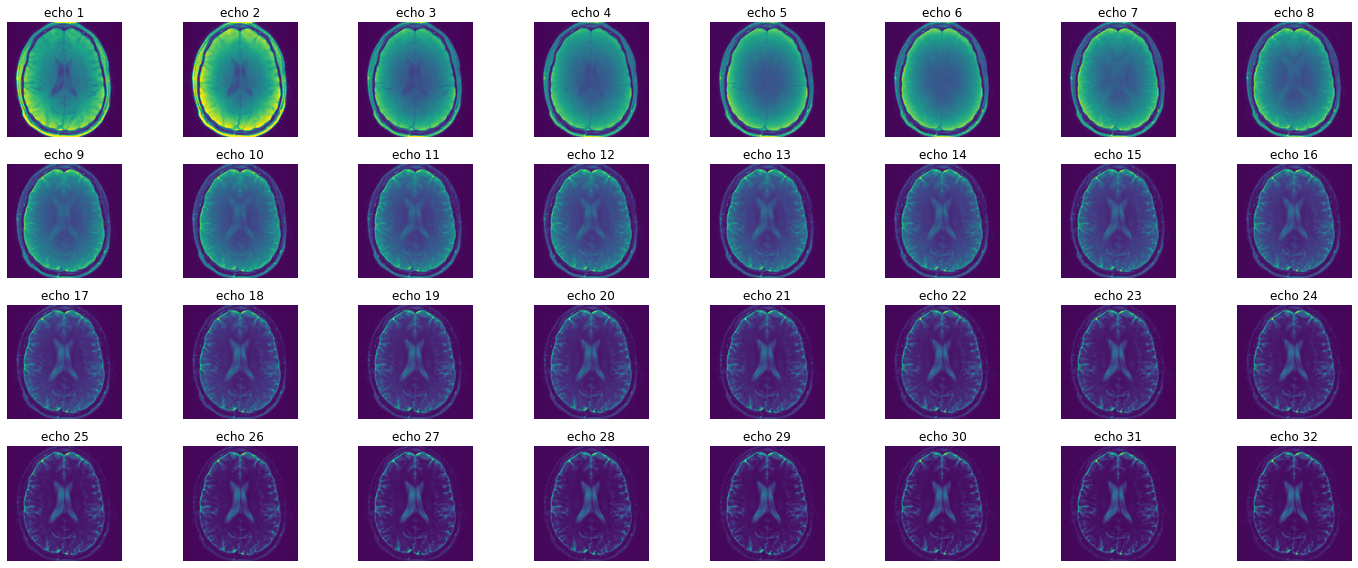

In [54]:
# The following function plots the 32 echoes for the 8th slice.
se.plot_all_echoes(img_data, slice_num=8, rows=4, columns=8, fig_size=(20,8), tight=True)

In [81]:
### Carry out the T2 spectrum using the neural network model trained above
NN_predict_spectrum = se.NN_predict_4D_decay(img_data, model)

/export01/data/Hanwen/SAME-ECOS/SAME_ECOS_functions.py:635: RuntimeWarning: invalid value encountered in true_divide
  decay_flat_norm = decay_flat / (decay_flat[:, 0].reshape(


In [68]:
### The last dimension of the 'se.quantitative_map_production' output the following 5 metrics (MWF, MWGMT2, IEWF, IEWGMT2, GMT2)
NN_predict_metrics = se.quantitative_map_production(t2_basis,
                                                    NN_predict_spectrum,
                                                    MW_low_cutoff=0,
                                                    MW_high_cutoff=40,
                                                    IEW_low_cutoff=40,
                                                    IEW_high_cutoff=200)

(128, 128, 16, 5)

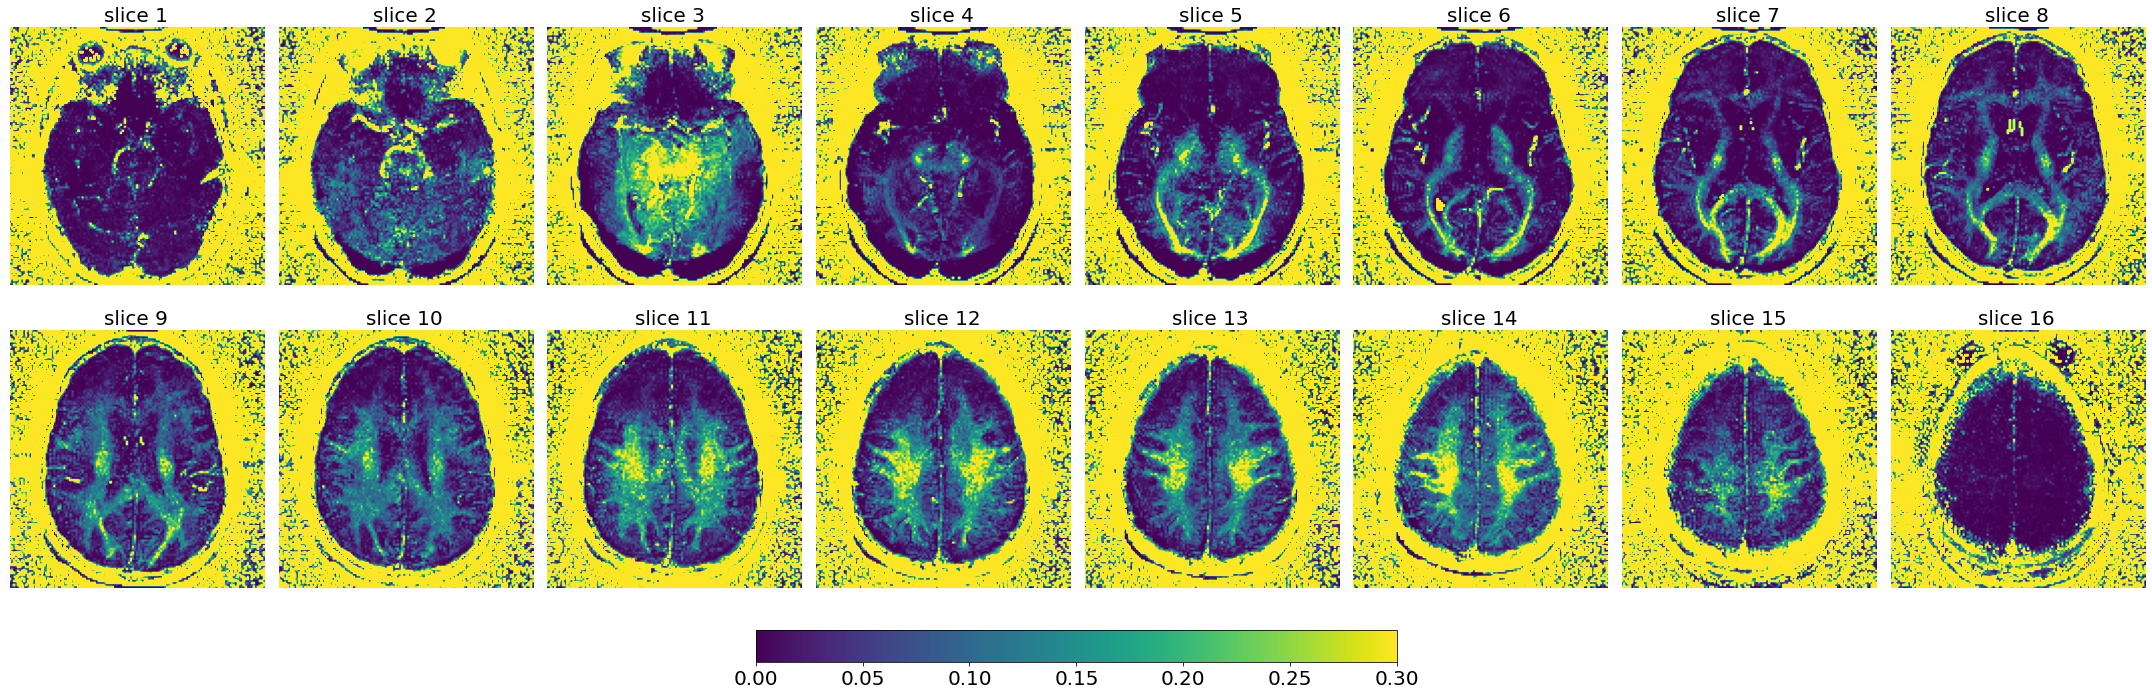

In [87]:
### plot the MWF map of all slices
se.plot_maps_slice(NN_predict_metrics[:,:,:,0], nrow=2, ncol=8, vmin=0, vmax=0.3)